In [1]:
import kagglehub
import os
from PIL import Image
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
from torchvision.tv_tensors import Mask as MaskTensor
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics.segmentation import DiceScore, MeanIoU
import segmentation_models_pytorch as smp
from tqdm import tqdm
import optuna

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Device: {device}")

Device: mps


# Download latest version from kaggle

In this project I use dataset from https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel.

This dataset is already divided to train and test data. Each consist images of retina (with visible blood vessels) and mask which consist only blood vessels as target to segmentation.

In [2]:
path = kagglehub.dataset_download("abdallahwagih/retina-blood-vessel")
path = os.path.join(path, "Data")
print("Path to dataset files:", path)

Path to dataset files: /Users/dami/.cache/kagglehub/datasets/abdallahwagih/retina-blood-vessel/versions/1/Data


In [3]:
print(f"Number of samples in train set: {len(os.listdir(os.path.join(path, 'Train', 'image')))}")
print(f"Number of samples in test set : {len(os.listdir(os.path.join(path, 'Test', 'image')))}")

Number of samples in train set: 80
Number of samples in test set : 20


In [4]:
image: Image = Image.open(os.path.join(path, "Train", "image", "1.png"))
mask: Image = Image.open(os.path.join(path, "Train", "mask", "1.png"))

print(
    f"Images in dataset have size: {image.size} and are in {'GrayScale' if image.mode == 'L' else image.mode} mode, so have {len(image.getbands())} channels.")
print(
    f"Masks (target) in dataset have size: {mask.size} and are in {'GrayScale' if mask.mode == 'L' else mask.mode} mode, so have {len(mask.getbands())} channels.")

Images in dataset have size: (512, 512) and are in RGB mode, so have 3 channels.
Masks (target) in dataset have size: (512, 512) and are in GrayScale mode, so have 1 channels.


# Making custom dataset class

I'm making dataset to load images and masks, so I decided to create custom Dataset.

In [5]:

unet_size = 512


class ImageDataSet(Dataset):
    def __init__(self, directory_path: str = os.path.join(path, "Train"), n_samples: int = 80, sample_transform=None,
                 target_transform=None, augmentation_transform=None):
        """
        :param directory_path: path to directory,
        :param n_samples: Number of samples in dataset,
        :param sample_transform: transform to use on every sample (image),
        :param target_transform: transform to use on every target (mask).
        """
        super(ImageDataSet, self).__init__()
        self.X_transform = sample_transform
        self.Y_transform = target_transform
        self.augmentation_transform = augmentation_transform
        self.X = []
        self.Y = []

        for i in range(n_samples):
            try:
                image_path = os.path.join(directory_path, "image", f"{i}.png")
                mask_path = os.path.join(directory_path, "mask", f"{i}.png")
                image = self._load_transform_(image_path, target=False)
                mask = self._load_transform_(mask_path, target=True)
            except Exception as e:
                print(e)
                continue
            self.X.append(image)
            self.Y.append(mask)
        self.X = torch.stack(self.X)
        self.Y = torch.stack(self.Y)

    def _load_transform_(self, path, target=False):
        image = np.array(Image.open(path))
        if not target:
            return self.X_transform(image) if self.X_transform else image
        else:
            return self.Y_transform(image) if self.Y_transform else image

    def __getitem__(self, idx):
        return self.augmentation_transform(self.X[idx], MaskTensor(self.Y[idx])) if self.augmentation_transform else (
            self.X[idx], self.Y[idx])

    def __len__(self):
        return len(self.X)


# I want to make transforms to change masks values from iterval [0; 1] to binary set {0; 1}
class NormalizeToIndex():
    def __init__(self, treshold: float = 0.5):
        """
        :param treshold: treshold to change continuosu data do binary data. If pixel_continuous_value > treshold, then pixel_binary_value <- 1 else pixel_binary_value <- 0
        """
        self.treshold = treshold

    def __call__(self, y: torch.Tensor):
        return torch.where(y > self.treshold, 1, 0).long()


# Searching for best treshold to making binary mask

I should choose perfect treshold to make binary values masks from continuous values masks:

In [6]:
# Making Dataset with non binary mask

train_dataset = ImageDataSet(
    n_samples=5,
    sample_transform=transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Resize(unet_size)
    ]),
    target_transform=transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Resize(unet_size),

    ]))

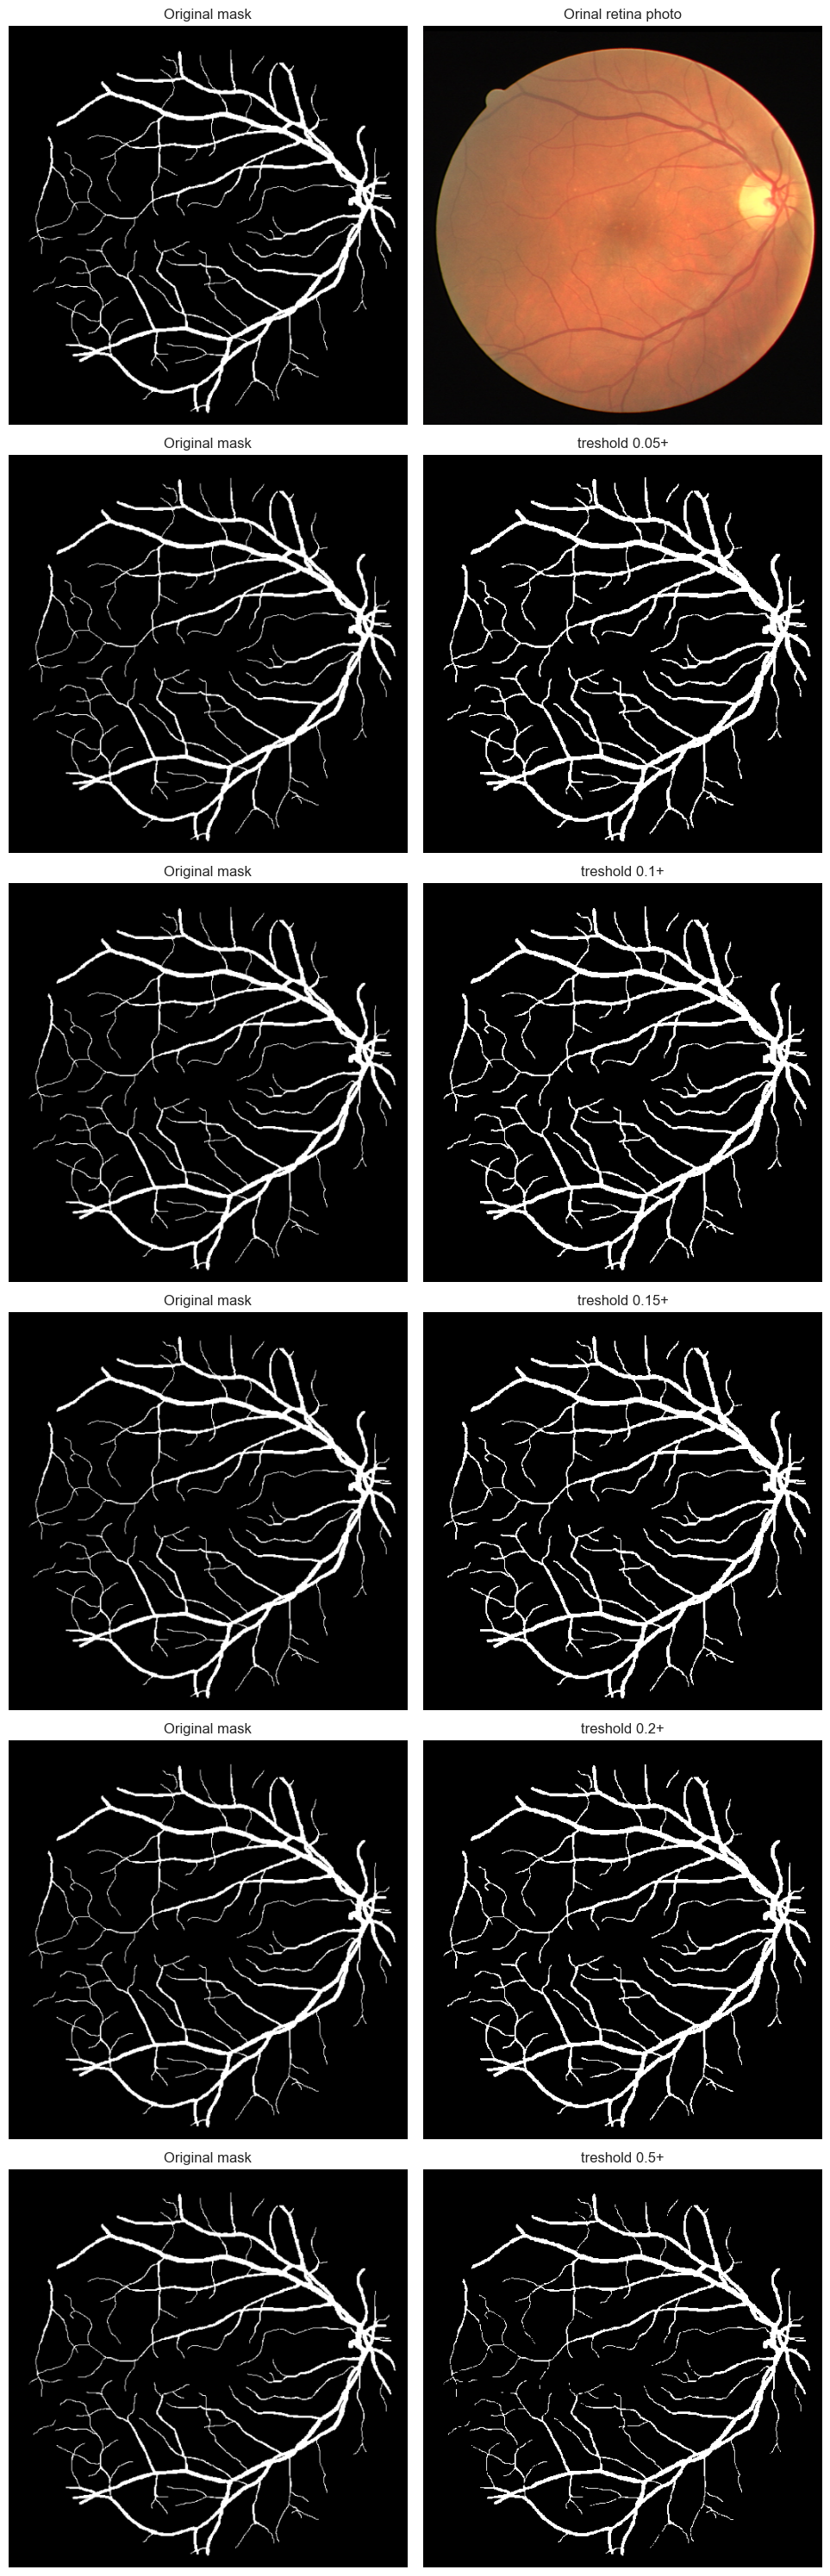

In [7]:
idx = 1  # number of sample in dataset to test some tresholds
image = train_dataset[idx][0].permute(1, 2, 0)
mask = train_dataset[idx][1].squeeze()

fig, ax = plt.subplots(6, 2, figsize=(10, 30))
plt.gray()

for i in range(6):
    ax[i, 0].imshow(mask)
    ax[i, 0].set_title("Original mask")

ax[0, 1].imshow(image)
ax[0, 1].set_title("Orinal retina photo")
ax[1, 1].imshow(mask > 0.05)
ax[1, 1].set_title("treshold 0.05+")
ax[2, 1].imshow(mask > 0.1)
ax[2, 1].set_title("treshold 0.1+")
ax[3, 1].imshow(mask > 0.15)
ax[3, 1].set_title("treshold 0.15+")
ax[4, 1].imshow(mask > 0.2)
ax[4, 1].set_title("treshold 0.2+")
ax[5, 1].imshow(mask > 0.5)
ax[5, 1].set_title("treshold 0.5+")

[a.set_axis_off() for a in ax.ravel()]
plt.tight_layout()
plt.show()



So probably the best treshold will be 0.15.

# Computing mean and std of images in train dataset

In [8]:
train_loader = DataLoader(train_dataset, batch_size=80)
for X,y in train_loader:
    mean = X.mean([0,2,3])
    std = X.std([0,2,3])

# Making final datasets and dataloaders

After choosing treshold, it's time to make right train and test datasets.

In [9]:
# Making dataset with binary mask

train_dataset = ImageDataSet(
    directory_path=os.path.join(path, "Train"),
    n_samples=80,
    sample_transform=transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean = mean, std = std),
        transforms.Resize(unet_size),

    ]),
    target_transform=transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Resize(unet_size),
        NormalizeToIndex(treshold=0.15),

    ]),
    augmentation_transform=transforms.Compose([
        transforms.RandomRotation(180),
        # transforms.RandomApply([
        #     transforms.RandomResizedCrop(unet_size, scale=(2.5 / 4, 1), ratio=(1, 1))
        # ], p=1)  # Eventually i could modify probability of doing Crop

    ])
)

test_dataset = ImageDataSet(
    directory_path=os.path.join(path, "Test"),
    n_samples=20,
    sample_transform=transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean = mean, std = std),
        transforms.Resize(unet_size),

    ]),
    target_transform=transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Resize(unet_size),
        NormalizeToIndex(treshold=0.15)
    ]))

In [10]:
# making dataoaders from datasets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initializing unet model

In this project to avoid long time training I decided to use pre-trained model.

Unet is famous model to making medical segmenation so I use it.

In [31]:
unet = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    # activation="sigmoid"
)
sigmoid = nn.Sigmoid()  # to better training (loss function prefer logits instead of probability) I decided to not use sigmoid in model

# Training

I make useful function to train model.

In [32]:
def train(model=unet, output_activation=sigmoid, train_loader=train_loader, val_loader=test_loader, EPOCHS=10, lr=1e-3,
          scheduler_step_size=10, scheduler_gamma=0.1):
    """
    :param model: model to train, default is unet
    :param output_activation: activation function to use on logits from model
    :param train_loader: dataloader with train data
    :param EPOCHS: number of epochs to train
    :param val_loader: dataloader with test data
    :param lr: learning rate to use in optimizer
    :param scheduler_step_size: period of learning rate decay
    :param scheduler_gamma: Multiplicative factor of learning rate decay
    :return: tuple of 4 lists, every list consist scores per epoch. Scores are: training IoU (JaccardIndex), testing IoU, training F1 (DiceScore), testing F1
    """
    model.to(device)

    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    # I tested two similar losses and sum of them, but the best results gave JaccardLoss
    # criterion = smp.losses.JaccardLoss(mode="binary", from_logits=True)  #this is IoU_loss
    criterion = smp.losses.DiceLoss(mode="binary", from_logits=True)  #this is F1_loss

    iou_metric = MeanIoU(num_classes=2, input_format="index", include_background=False).to(device)
    dice_metric = DiceScore(num_classes=2, input_format="index", include_background=False).to(device)
    train_iou_scores = []
    eval_iou_scores = []
    train_dice_scores = []
    eval_dice_scores = []

    print("Start training:")
    for i in tqdm(range(EPOCHS)):
        model.train()
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()

            Y_pred = model(X)
            loss = (criterion(Y_pred, Y))
            loss.backward()
            optimizer.step()

            Y_pred = (output_activation(Y_pred) > 0.5).long()
            iou_metric.update(Y_pred, Y)
            dice_metric.update(Y_pred, Y)

        train_iou_scores.append(iou_metric.compute().item())
        train_dice_scores.append(dice_metric.compute().item())
        iou_metric.reset()
        dice_metric.reset()

        model.eval()
        with torch.no_grad():
            for X, Y in val_loader:
                X = X.to(device)
                Y = Y.to(device)
                Y_pred = (output_activation(model(X)) > 0.5).to(torch.long)

                iou_metric.update(Y_pred, Y)
                dice_metric.update(Y_pred, Y)

            eval_iou_scores.append(iou_metric.compute().item())
            eval_dice_scores.append(dice_metric.compute().item())
            iou_metric.reset()
            dice_metric.reset()

        # I dont print loss, because score = 1 - loss, do it is the SAME
        print(
            f"Epoch: {str(i + 1).zfill(2)} | Train_IoU_score: {train_iou_scores[-1]:.4f}, Test_IoU_score: {eval_iou_scores[-1]:.4f} | Train_f1_score: {train_dice_scores[-1]:.4f}, Test_f1_score: {eval_dice_scores[-1]:.4f} | Learning_rate: {optimizer.param_groups[0]['lr']}")

        lr_scheduler.step()

    print("End training")
    model.to("cpu")

    return train_iou_scores, train_dice_scores, eval_iou_scores, eval_dice_scores


train_iou_scores, train_f1_scores, eval_iou_scores, eval_f1_scores = train(EPOCHS=30, lr=0.001, scheduler_step_size=20)
# unet.load_state_dict(torch.load(os.path.join("unet_results", "model_weights_scheduler_Jaccard_no_crop.pth")))
# train_iou_scores, train_f1_scores, eval_iou_scores, eval_f1_scores = torch.load(os.path.join("unet_results", "training_scores_scheduler_Jaccard_no_crop.pth"))

Start training:


  3%|▎         | 1/30 [00:12<06:11, 12.82s/it]

Epoch: 01 | Train_IoU_score: 0.2070, Test_IoU_score: 0.1068 | Train_f1_score: 0.3371, Test_f1_score: 0.1989 | Learning_rate: 0.001


  7%|▋         | 2/30 [00:23<05:30, 11.81s/it]

Epoch: 02 | Train_IoU_score: 0.3564, Test_IoU_score: 0.1298 | Train_f1_score: 0.5240, Test_f1_score: 0.2379 | Learning_rate: 0.001


 10%|█         | 3/30 [00:34<04:58, 11.04s/it]

Epoch: 03 | Train_IoU_score: 0.4182, Test_IoU_score: 0.3016 | Train_f1_score: 0.5876, Test_f1_score: 0.4627 | Learning_rate: 0.001


 13%|█▎        | 4/30 [00:45<04:46, 11.02s/it]

Epoch: 04 | Train_IoU_score: 0.4849, Test_IoU_score: 0.4444 | Train_f1_score: 0.6514, Test_f1_score: 0.6258 | Learning_rate: 0.001


 17%|█▋        | 5/30 [00:57<04:49, 11.59s/it]

Epoch: 05 | Train_IoU_score: 0.5351, Test_IoU_score: 0.4860 | Train_f1_score: 0.6958, Test_f1_score: 0.6617 | Learning_rate: 0.001


 20%|██        | 6/30 [01:11<04:54, 12.26s/it]

Epoch: 06 | Train_IoU_score: 0.5773, Test_IoU_score: 0.5497 | Train_f1_score: 0.7312, Test_f1_score: 0.7160 | Learning_rate: 0.001


 23%|██▎       | 7/30 [01:28<05:19, 13.90s/it]

Epoch: 07 | Train_IoU_score: 0.6038, Test_IoU_score: 0.5623 | Train_f1_score: 0.7523, Test_f1_score: 0.7254 | Learning_rate: 0.001


 27%|██▋       | 8/30 [01:39<04:44, 12.93s/it]

Epoch: 08 | Train_IoU_score: 0.6101, Test_IoU_score: 0.6135 | Train_f1_score: 0.7569, Test_f1_score: 0.7628 | Learning_rate: 0.001


 30%|███       | 9/30 [01:50<04:16, 12.22s/it]

Epoch: 09 | Train_IoU_score: 0.6275, Test_IoU_score: 0.6376 | Train_f1_score: 0.7706, Test_f1_score: 0.7797 | Learning_rate: 0.001


 33%|███▎      | 10/30 [02:02<04:04, 12.22s/it]

Epoch: 10 | Train_IoU_score: 0.6394, Test_IoU_score: 0.6250 | Train_f1_score: 0.7796, Test_f1_score: 0.7722 | Learning_rate: 0.001


 37%|███▋      | 11/30 [02:13<03:48, 12.05s/it]

Epoch: 11 | Train_IoU_score: 0.6456, Test_IoU_score: 0.6385 | Train_f1_score: 0.7842, Test_f1_score: 0.7801 | Learning_rate: 0.001


 40%|████      | 12/30 [02:24<03:30, 11.69s/it]

Epoch: 12 | Train_IoU_score: 0.6511, Test_IoU_score: 0.6504 | Train_f1_score: 0.7884, Test_f1_score: 0.7893 | Learning_rate: 0.001


 43%|████▎     | 13/30 [02:35<03:13, 11.36s/it]

Epoch: 13 | Train_IoU_score: 0.6565, Test_IoU_score: 0.5749 | Train_f1_score: 0.7923, Test_f1_score: 0.7299 | Learning_rate: 0.001


 47%|████▋     | 14/30 [02:46<02:59, 11.19s/it]

Epoch: 14 | Train_IoU_score: 0.6551, Test_IoU_score: 0.5248 | Train_f1_score: 0.7912, Test_f1_score: 0.6893 | Learning_rate: 0.001


 50%|█████     | 15/30 [02:56<02:43, 10.90s/it]

Epoch: 15 | Train_IoU_score: 0.6609, Test_IoU_score: 0.6669 | Train_f1_score: 0.7955, Test_f1_score: 0.7996 | Learning_rate: 0.001


 53%|█████▎    | 16/30 [03:06<02:31, 10.79s/it]

Epoch: 16 | Train_IoU_score: 0.6643, Test_IoU_score: 0.6773 | Train_f1_score: 0.7979, Test_f1_score: 0.8059 | Learning_rate: 0.001


 57%|█████▋    | 17/30 [03:17<02:17, 10.60s/it]

Epoch: 17 | Train_IoU_score: 0.6693, Test_IoU_score: 0.6886 | Train_f1_score: 0.8015, Test_f1_score: 0.8112 | Learning_rate: 0.001


 60%|██████    | 18/30 [03:27<02:06, 10.54s/it]

Epoch: 18 | Train_IoU_score: 0.6702, Test_IoU_score: 0.6861 | Train_f1_score: 0.8022, Test_f1_score: 0.8107 | Learning_rate: 0.001


 63%|██████▎   | 19/30 [03:37<01:53, 10.30s/it]

Epoch: 19 | Train_IoU_score: 0.6729, Test_IoU_score: 0.6810 | Train_f1_score: 0.8042, Test_f1_score: 0.8076 | Learning_rate: 0.001


 67%|██████▋   | 20/30 [03:47<01:41, 10.20s/it]

Epoch: 20 | Train_IoU_score: 0.6724, Test_IoU_score: 0.6834 | Train_f1_score: 0.8038, Test_f1_score: 0.8089 | Learning_rate: 0.001


 70%|███████   | 21/30 [03:56<01:30, 10.03s/it]

Epoch: 21 | Train_IoU_score: 0.6766, Test_IoU_score: 0.6915 | Train_f1_score: 0.8069, Test_f1_score: 0.8151 | Learning_rate: 0.0001


 73%|███████▎  | 22/30 [04:06<01:18,  9.87s/it]

Epoch: 22 | Train_IoU_score: 0.6788, Test_IoU_score: 0.6908 | Train_f1_score: 0.8083, Test_f1_score: 0.8158 | Learning_rate: 0.0001


 77%|███████▋  | 23/30 [04:16<01:09,  9.87s/it]

Epoch: 23 | Train_IoU_score: 0.6793, Test_IoU_score: 0.6937 | Train_f1_score: 0.8087, Test_f1_score: 0.8165 | Learning_rate: 0.0001


 80%|████████  | 24/30 [04:25<00:59,  9.86s/it]

Epoch: 24 | Train_IoU_score: 0.6811, Test_IoU_score: 0.6959 | Train_f1_score: 0.8101, Test_f1_score: 0.8172 | Learning_rate: 0.0001


 83%|████████▎ | 25/30 [04:36<00:49,  9.96s/it]

Epoch: 25 | Train_IoU_score: 0.6815, Test_IoU_score: 0.6950 | Train_f1_score: 0.8103, Test_f1_score: 0.8173 | Learning_rate: 0.0001


 87%|████████▋ | 26/30 [04:46<00:40, 10.01s/it]

Epoch: 26 | Train_IoU_score: 0.6826, Test_IoU_score: 0.6945 | Train_f1_score: 0.8110, Test_f1_score: 0.8171 | Learning_rate: 0.0001


 90%|█████████ | 27/30 [04:57<00:30, 10.27s/it]

Epoch: 27 | Train_IoU_score: 0.6817, Test_IoU_score: 0.6963 | Train_f1_score: 0.8104, Test_f1_score: 0.8181 | Learning_rate: 0.0001


 93%|█████████▎| 28/30 [05:08<00:21, 10.64s/it]

Epoch: 28 | Train_IoU_score: 0.6823, Test_IoU_score: 0.6969 | Train_f1_score: 0.8109, Test_f1_score: 0.8185 | Learning_rate: 0.0001


 97%|█████████▋| 29/30 [05:19<00:10, 10.68s/it]

Epoch: 29 | Train_IoU_score: 0.6822, Test_IoU_score: 0.6962 | Train_f1_score: 0.8108, Test_f1_score: 0.8180 | Learning_rate: 0.0001


100%|██████████| 30/30 [05:29<00:00, 10.98s/it]

Epoch: 30 | Train_IoU_score: 0.6834, Test_IoU_score: 0.6958 | Train_f1_score: 0.8116, Test_f1_score: 0.8177 | Learning_rate: 0.0001
End training


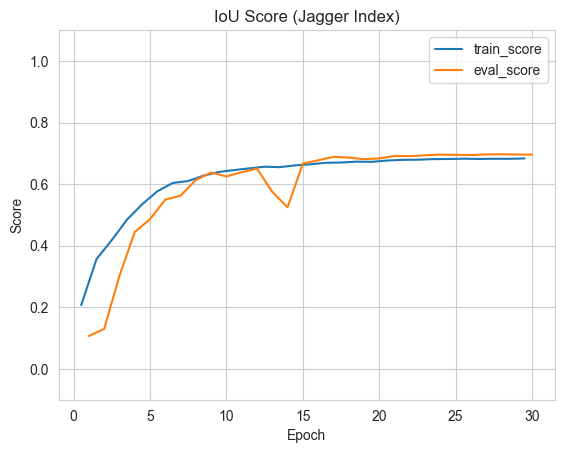

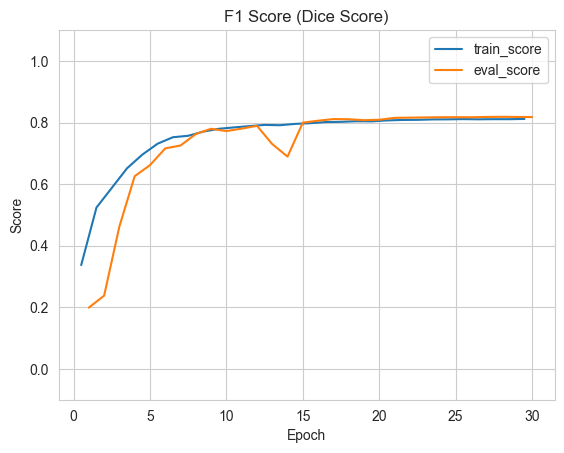

In [33]:
def plot_train_eval_scores(train_scores: list[float], eval_scores: list[float], title: str | None = None,
                           margin: float = 0.1):
    """
    :param train_scores: list of train set scores per epoch,
    :param eval_scores: list of eval scores per epoch,
    :param title: title of plot, if None then without title,
    :param margin: margin of plots,
    :return: None
    """

    if len(train_scores) != len(eval_scores):
        raise Exception(
            f"Mismatch length of train_scores ({len(train_scores)}), with eval_scores ({len(eval_scores)}).")

    epochs = list(range(1, len(train_scores) + 1))
    plt.plot([i - 0.5 for i in epochs], train_scores,
             label="train_score")  # I move plot, because some scores was compute before end of epoch
    plt.plot(epochs, eval_scores,
             label="eval_score")  # I don't move, because every score was computing after end of epoch
    if title:
        plt.title(title)
    plt.ylim(0 - margin, 1 + margin)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.show()


plot_train_eval_scores(train_iou_scores, eval_iou_scores, title="IoU Score (Jagger Index)")
plot_train_eval_scores(train_f1_scores, eval_f1_scores, title="F1 Score (Dice Score)")

In [34]:
print(f"Train IoU score: {train_iou_scores[-1]}")
print(f"Test  IoU score: {eval_iou_scores[-1]}")
print(f"Train F1  score: {train_f1_scores[-1]}")
print(f"Test  F1  score: {eval_f1_scores[-1]}")

Train IoU score: 0.683384895324707
Test  IoU score: 0.6957716941833496
Train F1  score: 0.8116477727890015
Test  F1  score: 0.8176692724227905


# Checking results on example sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


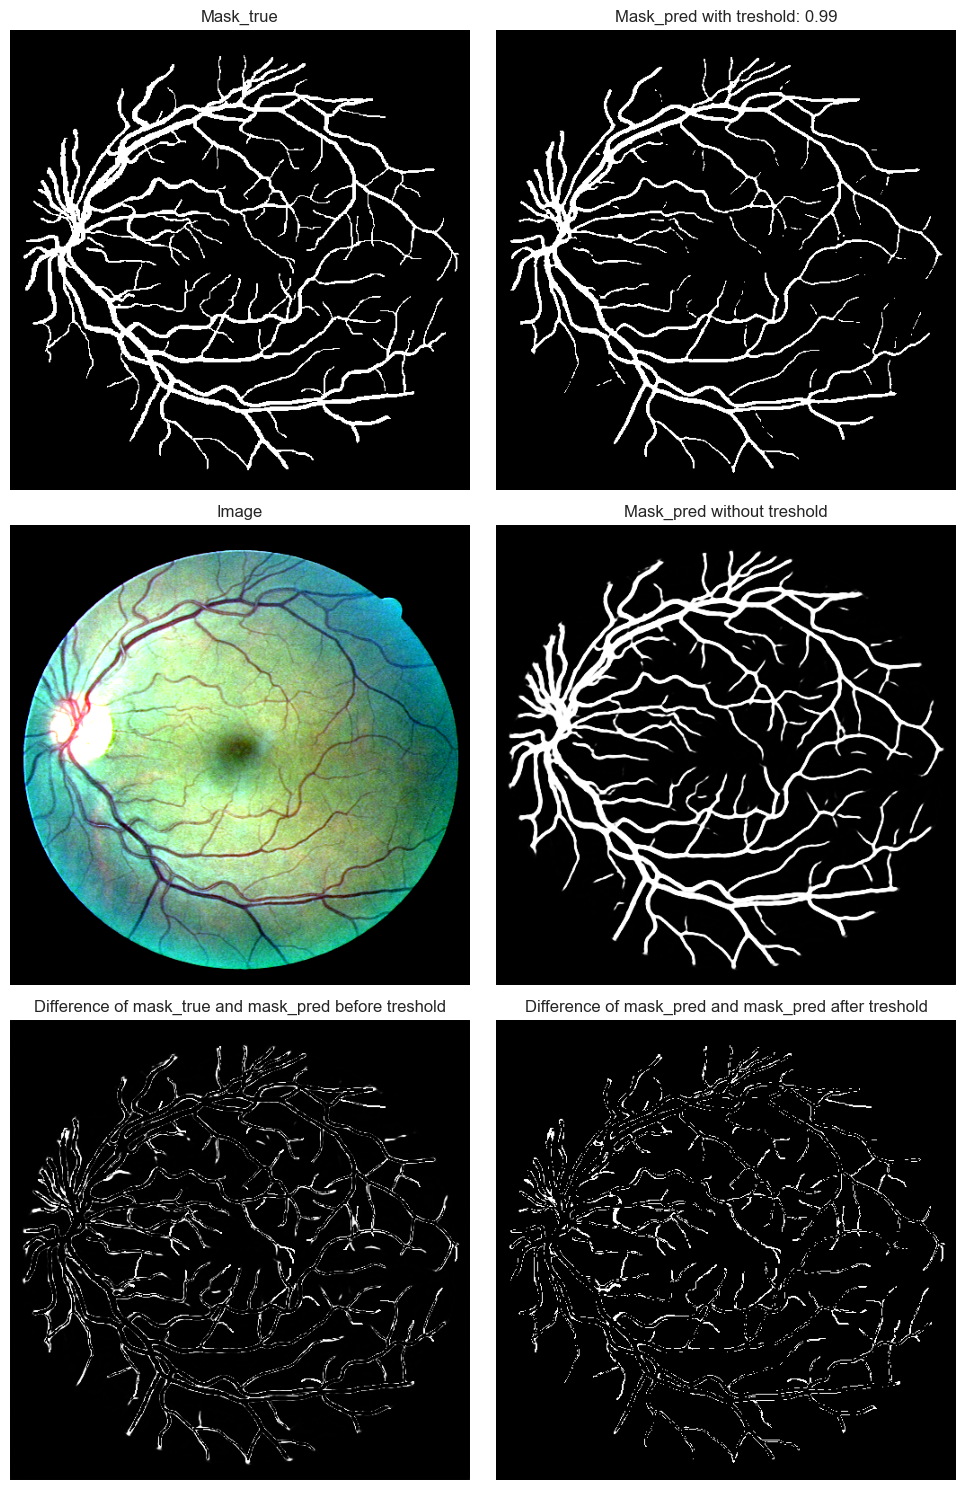

In [37]:
idx = 0  # number of sample
treshold = 0.99  # treshold to change pobability output from model to index of class: 1 if blood vessels, 0 if background
unet.to("cpu")

with torch.no_grad():
    unet.eval()

    image, mask_true = test_dataset[idx]
    mask_true = mask_true.squeeze()
    mask_pred = sigmoid(unet(image.unsqueeze(0)))
    mask_pred_after_treshold = (mask_pred.squeeze() > treshold).int()
    image = image.permute(1, 2, 0)
    mask_pred = mask_pred.squeeze()

    fig, ax = plt.subplots(3, 2, figsize=(10, 15))

    ax[0, 0].imshow(mask_true)
    ax[0, 0].set_title("Mask_true")
    ax[0, 1].imshow(mask_pred_after_treshold)
    ax[0, 1].set_title(f"Mask_pred with treshold: {treshold}")
    ax[1, 0].imshow(image)
    ax[1, 0].set_title("Image")
    ax[1, 1].imshow(mask_pred)
    ax[1, 1].set_title("Mask_pred without treshold")
    ax[2, 0].imshow((mask_true - mask_pred).abs())
    ax[2, 0].set_title("Difference of mask_true and mask_pred before treshold")
    ax[2, 1].imshow((mask_true - mask_pred_after_treshold).abs())
    ax[2, 1].set_title("Difference of mask_pred and mask_pred after treshold")

    for a in ax.ravel():
        a.set_axis_off()
    plt.tight_layout()
    plt.show()


In [38]:
# os.makedirs("unet_results", exist_ok=True)
# torch.save(unet.state_dict(), os.path.join("unet_results", "model_weights_scheduler_Jaccard_no_crop.pth"))
# torch.save((train_iou_scores, train_f1_scores, eval_iou_scores, eval_f1_scores), os.path.join("unet_results", "training_scores_scheduler_Jaccard_no_crop.pth"))

# Optuna to search best treeshold to increase score

In [39]:
def best_treeshold(dataloader : DataLoader = test_loader,
                   model : nn.Module = unet,
                   activation_output : nn.Module = sigmoid,
                   score_function: torchmetrics.Metric = MeanIoU(num_classes=2, input_format="index", include_background=False),
                   n_trials = 30
                   ):
    """
    :param dataloader: DataLoader with images and masks,
    :param model: Model to predict masks,
    :param activation_output: Activation function to use on logits,
    :param score_function: Metric to compute score,
    :param n_trials: Number of trials in study,
    :return: Optuna study object.
    """


    def objective(trial : optuna.trial.Trial):
        treshold = trial.suggest_float("treshold", 0.0, 1.0)
        model.eval()
        for image, mask in dataloader:
            mask_pred = (activation_output(model(image)) > treshold).long()
            score_function.update(mask_pred, mask)

        return score_function.compute().item()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    return study

study = best_treeshold(score_function=DiceScore(num_classes=2, input_format="index", include_background=False).to(device))
print(f"Best treshold value: {study.best_params['treshold']}")
print(f"Dest score: {study.best_value}")



[I 2025-04-22 01:00:38,969] A new study created in memory with name: no-name-ae416801-2c23-4fe1-9ef2-684a0dd40740
[I 2025-04-22 01:00:49,165] Trial 0 finished with value: 0.8167682886123657 and parameters: {'treshold': 0.40495397291671587}. Best is trial 0 with value: 0.8167682886123657.
[I 2025-04-22 01:00:59,272] Trial 1 finished with value: 0.8149114847183228 and parameters: {'treshold': 0.24920262507234525}. Best is trial 0 with value: 0.8167682886123657.
[I 2025-04-22 01:01:09,586] Trial 2 finished with value: 0.8157114386558533 and parameters: {'treshold': 0.45765313134277286}. Best is trial 0 with value: 0.8167682886123657.
[I 2025-04-22 01:01:20,008] Trial 3 finished with value: 0.8149563074111938 and parameters: {'treshold': 0.23804606454431276}. Best is trial 0 with value: 0.8167682886123657.
[I 2025-04-22 01:01:30,538] Trial 4 finished with value: 0.8150209188461304 and parameters: {'treshold': 0.812158549165923}. Best is trial 0 with value: 0.8167682886123657.
[I 2025-04-22

Best treshold value: 0.40495397291671587
Dest score: 0.8167682886123657


Unfortunately this have no effect, the best treshold was 0.5 which i used in training.